In [1]:
import sys
import os
sys.path.append(os.getcwd())
import init

import tensorflow as tf

STBX not loaded: No module named 'pandas'
init loaded


In [2]:
MODEL_NAME = 'pix2pix'
BATCH_SIZE = 1
SUFFIX = 'test'

SUBFOLDER = f'{init.TIMESTAMP}_{MODEL_NAME}_{BATCH_SIZE}x{init.TILESIZE}'
if SUFFIX is not None:
    SUBFOLDER += f'_{SUFFIX}'


In [3]:
path_logs = os.path.join(init.OUTPUT_ROOT, f'{SUBFOLDER}/logs/')
path_ckpt = os.path.join(init.OUTPUT_ROOT, f'{SUBFOLDER}/ckpt/')
path_imgs = os.path.join(init.OUTPUT_ROOT, f'{SUBFOLDER}/samples/')
path_model = os.path.join(init.OUTPUT_ROOT, f'{SUBFOLDER}/model/')
os.makedirs(path_logs, exist_ok=True)
os.makedirs(path_ckpt, exist_ok=True)
os.makedirs(path_imgs, exist_ok=True)
os.makedirs(path_model, exist_ok=True)


In [4]:
import importlib

# Dynamically import all classes in the directory
directory = 'model'
modules = []
for filename in os.listdir(directory):
    if filename.endswith('.py'):
        module_name = filename[:-3]
        modules.append(importlib.import_module("." + module_name, package=directory))

model = None
for module in modules:
    if module.__name__[-len(MODEL_NAME):] == MODEL_NAME:
        model = module.GAN(path_logs, path_ckpt, LAMBDA=100.0)

In [5]:
if init.ENVIRONMENT == 'blaze':
    import subprocess

    command = 'source /usr/local/cuda/CUDA_VISIBILITY.csh'
    process = subprocess.Popen(command, shell=True, executable="/bin/csh", stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()

    os.environ['CUDA_VISIBLE_DEVICES'] = stdout.decode()[-2]
    # os.environ['CUDA_HOME'] = '/opt/cuda/cuda-10.0'
    print(stdout.decode())

    command = 'source /server/opt/cuda/enable_cuda_11.0'
    process = subprocess.Popen(command, shell=True, executable="/bin/csh", stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()

    command = 'echo $CUDA_VISIBLE_DEVICES'
    process = subprocess.Popen(command, shell=True, executable="/bin/csh", stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    print(command)
    print(stdout.decode())

GPU 0 is in use
GPU 1 is in use
GPU 2 is in use
GPU 3 is in use
All GPUs are in use. Utilise the Windows vlab or the GPU enabled machines in labs 105 and 121.

echo $CUDA_VISIBLE_DEVICES
.



In [5]:
generator = model.generator
discriminator = model.discriminator


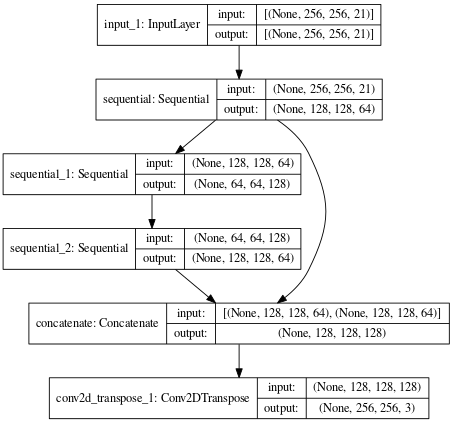

In [7]:


tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)